# Статистика

# Лабараторная работа 2

Ежов Дмитрий Александрович \
Соловьев Матвей Михайлович \
Трифoнов Василий Максимович


In [ ]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
from typing import Union, Optional
import math 
from scipy.stats import gaussian_kde 


In [74]:
N = 1024

In [ ]:
class DistributionAnalyzer:
    """
    Analyzes and visualizes a given data distribution.
    """
    def __init__(self, data: np.ndarray, dist_type: str = 'continuous', name: str = 'Unnamed Distribution'):
        self.data = data
        self.dist_type = dist_type 
        self.name = name
        self._stats = {}

    def calculate_statistics(self) -> dict:
        """Calculate all descriptive statistics."""
        q1, median, q3 = np.percentile(self.data, [25, 50, 75])
        iqr = q3 - q1

        # Handle mode for continuous vs discrete
        if self.dist_type == 'discrete':
            # Use bincount for discrete mode
            counts = np.bincount(self.data.astype(int))
            mode_val = np.argmax(counts) if counts.size > 0 else np.nan
        else:
            # For continuous, mode is less meaningful, stats.mode finds the most frequent value
            mode_result = stats.mode(self.data, keepdims=False) # Use keepdims=False for newer scipy
            mode_val = mode_result.mode if mode_result.count > 1 else np.nan # Only report mode if it appears more than once


        mean_val = np.mean(self.data)
        std_val = np.std(self.data) # Biased standard deviation

        self._stats = {
            'quantiles': [q1, median, q3], # Квартили
            'mean': mean_val, # Выборочное среднее
            'median': median, # Медиана
            'mode': mode_val, # Мода
            'range': np.ptp(self.data), # Размах выборки: max(X) - min(X)
            'iqr': iqr, # Интерквартильный размах
            'variance': np.var(self.data), # Дисперсия (смещенная): $\sigma^2 = \frac{1}{N}\sum_{i=1}^N (X_i - \bar{X})^2$
            'std': std_val, # Стандартное отклонение (смещенное): $\sqrt{Var(X)} = \sqrt{sigma^2}$
            'cov': (std_val / mean_val) if mean_val != 0 else float('inf'), # Коэффициент вариации: $CV = \sigma / \bar{X}$
            'mad': np.mean(np.abs(self.data - mean_val)), # Среднее абсолютное отклонение: $MAD = \frac{1}{N}\sum_{i=1}^N |X_i - \bar{X}|$
            'skew': stats.skew(self.data), # Коэффициент асимметрии (смещенный): $\gamma_1 = m_3 / \sigma^3$
            'kurtosis': stats.kurtosis(self.data), # Коэффициент эксцесса (смещенный, Fisher): $\gamma_2 = m_4 / \sigma^4 - 3$
            'raw_moments': [np.mean(self.data**k) for k in range(1, 6)], # Начальные моменты: $\mu'_k = E(X^k) = \frac{1}{N}\sum_{i=1}^N X_i^k$
            'central_moments': [stats.moment(self.data, moment=k) for k in range(1, 6)] # Центральные моменты: $\mu_k = E((X - E(X))^k) = \frac{1}{N}\sum_{i=1}^N (X_i - \bar{X})^k$
        }
        return self._stats

    def print_statistics(self):
        """Print formatted statistical summary."""
        if not self._stats:
            self.calculate_statistics()

        stats = self._stats
        print(f"--- Statistics for {self.name} ---")
        print(f"{'Quantiles':<25}: Q1={stats['quantiles'][0]:.4f}, Q2={stats['quantiles'][1]:.4f}, Q3={stats['quantiles'][2]:.4f}") # Квартили
        print(f"{'Central Tendency':<25}: Mean={stats['mean']:.4f}, Median={stats['median']:.4f}, Mode={stats['mode']:.4f}") # Меры центральной тенденции: Среднее, Медиана, Мода
        print(f"{'Variability':<25}: Range={stats['range']:.4f}, IQR={stats['iqr']:.4f}, Variance={stats['variance']:.4f}, Std={stats['std']:.4f}, Cov={stats['cov']:.4f}, MAD={stats['mad']:.4f}") # Меры вариабельности: Размах, Интерквартильный размах, Дисперсия, Стд. отклонение, Коэфф. вариации, Среднее абс. отклонение
        print(f"{'Shape':<25}: Skew={stats['skew']:.4f}, Kurtosis={stats['kurtosis']:.4f}") # Меры формы: Асимметрия, Эксцесс
        print("Raw Moments (1-5):") # Начальные моменты (1-5)
        for i, m in enumerate(stats['raw_moments']):
             print(f"  Order {i+1}: {m:.4f}")
        print("Central Moments (1-5):") # Центральные моменты (1-5)
        for i, m in enumerate(stats['central_moments']):
             print(f"  Order {i+1}: {m:.4f}")
        print("-" * (len(f"--- Statistics for {self.name} ---")))

    def plot_distribution(self, theoretical_dist: Optional[stats.rv_continuous] = None):
        """Visualize distribution with theoretical overlay and vaseplot."""
        print(f"\n--- Visualizations for {self.name} ---")
        fig, axes = plt.subplots(1, 3, figsize=(18, 5)) 

        # Empirical vs Theoretical CDF
        x_sorted = np.sort(self.data)
        y_ecdf = np.arange(1, len(x_sorted)+1)/len(x_sorted)
        axes[0].plot(x_sorted, y_ecdf, marker='.', linestyle='none', label='eCDF')
        if theoretical_dist:
            # Generate points for theoretical CDF
            x_cdf = np.linspace(np.min(self.data), np.max(self.data), 200)
            axes[0].plot(x_cdf, theoretical_dist.cdf(x_cdf), label='Theoretical CDF', color='red')
        axes[0].set_title('Empirical vs Theoretical CDF')
        axes[0].set_xlabel('Value')
        axes[0].set_ylabel('Cumulative Probability')
        axes[0].legend()
        axes[0].grid(True, linestyle='--', alpha=0.6)


        # Empirical Density/Probability Plot (Histogram or PMF)
        if self.dist_type == 'continuous':
            # Histograms with different binning strategies
            axes[1].set_title('Empirical vs Theoretical PDF (Histograms)')
            axes[1].set_xlabel('Value')
            axes[1].set_ylabel('Density')

            # Auto binning
            axes[1].hist(self.data, bins='auto', density=True, alpha=0.5, label='ePDF (Auto Bins)')

            # Freedman-Diaconis rule for binning
            iqr = np.subtract(*np.percentile(self.data, [75, 25]))
            bin_width_fd = 2 * iqr / (len(self.data)**(1/3))
            bins_fd = math.ceil((np.max(self.data) - np.min(self.data)) / bin_width_fd) if bin_width_fd > 0 else 'auto'
            if bins_fd != 'auto':
                 axes[1].hist(self.data, bins=bins_fd, density=True, alpha=0.5, label=f'ePDF (FD Bins: {bins_fd})')

            # Manual binning 
            axes[1].hist(self.data, bins=30, density=True, alpha=0.5, label='ePDF (Manual Bins: 30)')


            if theoretical_dist:
                x_pdf = np.linspace(np.min(self.data), np.max(self.data), 200)
                axes[1].plot(x_pdf, theoretical_dist.pdf(x_pdf), label='Theoretical PDF', color='red')

        else: # discrete
            axes[1].set_title('Empirical vs Theoretical PMF')
            axes[1].set_xlabel('Value')
            axes[1].set_ylabel('Probability')
            # Empirical PMF
            unique_values, counts = np.unique(self.data, return_counts=True)
            pmf_empirical = counts / len(self.data)
            axes[1].bar(unique_values, pmf_empirical, label='ePMF', alpha=0.7)

            if theoretical_dist:
                # Theoretical PMF
                x_pmf = np.arange(np.min(self.data), np.max(self.data) + 1)
                pmf_theoretical = theoretical_dist.pmf(x_pmf)
                axes[1].vlines(x_pmf, 0, pmf_theoretical, colors='r', linestyles='-', lw=2, label='Theoretical PMF')

        axes[1].legend()
        axes[1].grid(True, linestyle='--', alpha=0.6)

        # Vaseplot 
        axes[2].set_title('Vaseplot (Violin Plot)')
        axes[2].set_xlabel('Density') # X-axis represents density
        axes[2].set_ylabel('Value') # Y-axis represents the data value

        # Calculate KDE
        try:
            kde = gaussian_kde(self.data)
            y_values = np.linspace(np.min(self.data), np.max(self.data), 200)
            density = kde(y_values)

            # Plot the mirrored density
            axes[2].plot(density, y_values, color='blue', alpha=0.7)
            axes[2].plot(-density, y_values, color='blue', alpha=0.7)
            axes[2].fill_betweenx(y_values, density, -density, color='blue', alpha=0.2)

            # Add median and IQR lines
            q1, median, q3 = np.percentile(self.data, [25, 50, 75])
            axes[2].axhline(median, color='red', linestyle='-', linewidth=2, label=f'Median ({median:.4f})')
            axes[2].axhline(q1, color='red', linestyle='--', linewidth=1, label=f'Q1 ({q1:.4f})')
            axes[2].axhline(q3, color='red', linestyle='--', linewidth=1, label=f'Q3 ({q3:.4f})')

            # Set x-axis limits symmetrically around 0
            max_density = np.max(density)
            axes[2].set_xlim(-max_density * 1.1, max_density * 1.1)
            axes[2].legend()

        except np.linalg.LinAlgError:
            axes[2].text(0.5, 0.5, 'Could not calculate KDE for vaseplot',
                         horizontalalignment='center', verticalalignment='center',
                         transform=axes[2].transAxes, color='red')


        plt.tight_layout()
        plt.show()
        print("-" * (len(f"--- Visualizations for {self.name} ---")))


# Дискретное распределение - Распределение Пуассона


--- Statistics for Poisson Distribution ---
Quantiles                : Q1=3.0000, Q2=5.0000, Q3=6.0000
Central Tendency         : Mean=5.0205, Median=5.0000, Mode=4.0000
Variability              : Range=12.0000, IQR=3.0000, Variance=4.8091, Std=2.1930, Cov=0.4368, MAD=1.7555
Shape                    : Skew=0.3495, Kurtosis=-0.2479
Raw Moments (1-5):
  Order 1: 5.0205
  Order 2: 30.0146
  Order 3: 202.6631
  Order 4: 1500.2842
  Order 5: 11936.3193
Central Moments (1-5):
  Order 1: 0.0000
  Order 2: 4.8091
  Order 3: 3.6856
  Order 4: 63.6514
  Order 5: 134.2200
-------------------------------------------

--- Visualizations for Poisson Distribution ---


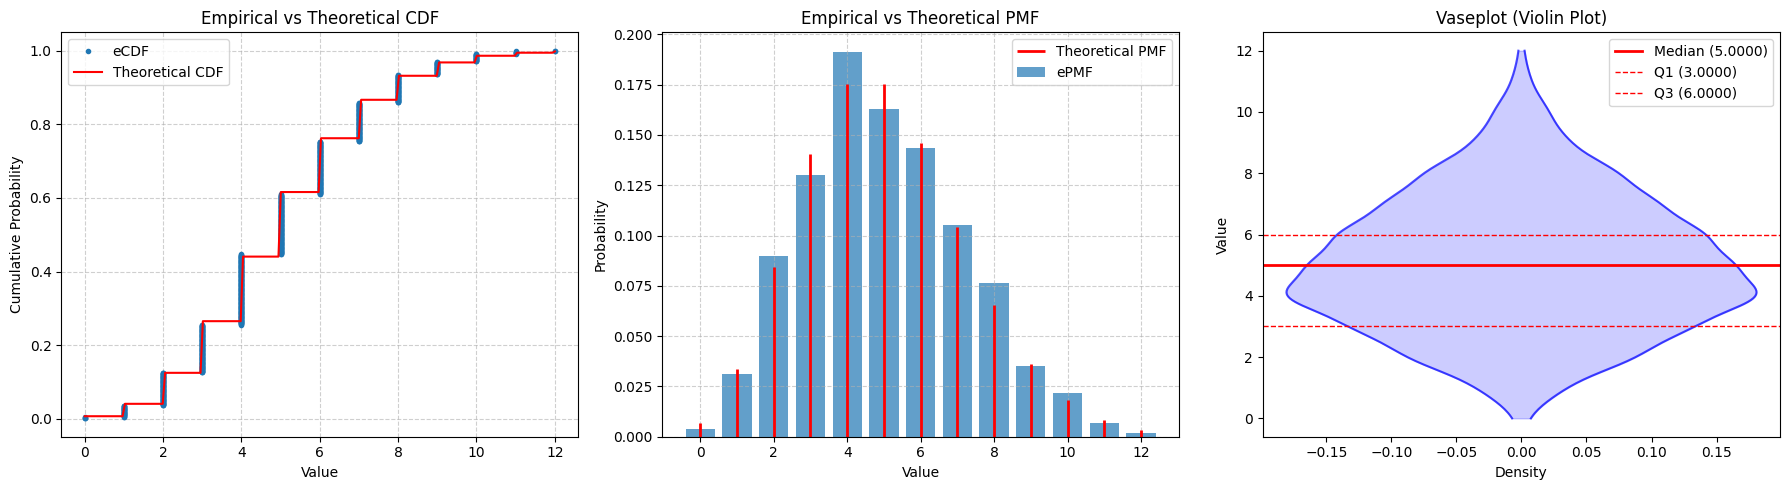

-----------------------------------------------


In [76]:
# --- Распределение Пуассона ---
# Параметр распределения Пуассона
lambda_poisson = 5

# 1. Генерация выборки
poisson_data = np.random.poisson(lam=lambda_poisson, size=N)

# 2. Анализ и визуализация
poisson_analyzer = DistributionAnalyzer(poisson_data, dist_type='discrete', name='Poisson Distribution')

# a) основные статистики
poisson_analyzer.print_statistics()

# b) визуализация
# For discrete distribution, theoretical_dist should be from scipy.stats.poisson
poisson_analyzer.plot_distribution(theoretical_dist=stats.poisson(mu=lambda_poisson))



# Непрерывное распределение - Распределение Вейбулла


--- Statistics for Weibull Distribution ---
Quantiles                : Q1=0.5120, Q2=0.8232, Q3=1.1558
Central Tendency         : Mean=0.8691, Median=0.8232, Mode=nan
Variability              : Range=2.3952, IQR=0.6438, Variance=0.2034, Std=0.4510, Cov=0.5189, MAD=0.3637
Shape                    : Skew=0.5642, Kurtosis=-0.0504
Raw Moments (1-5):
  Order 1: 0.8691
  Order 2: 0.9587
  Order 3: 1.2385
  Order 4: 1.7943
  Order 5: 2.8353
Central Moments (1-5):
  Order 1: 0.0000
  Order 2: 0.2034
  Order 3: 0.0518
  Order 4: 0.1220
  Order 5: 0.0830
-------------------------------------------

--- Visualizations for Weibull Distribution ---


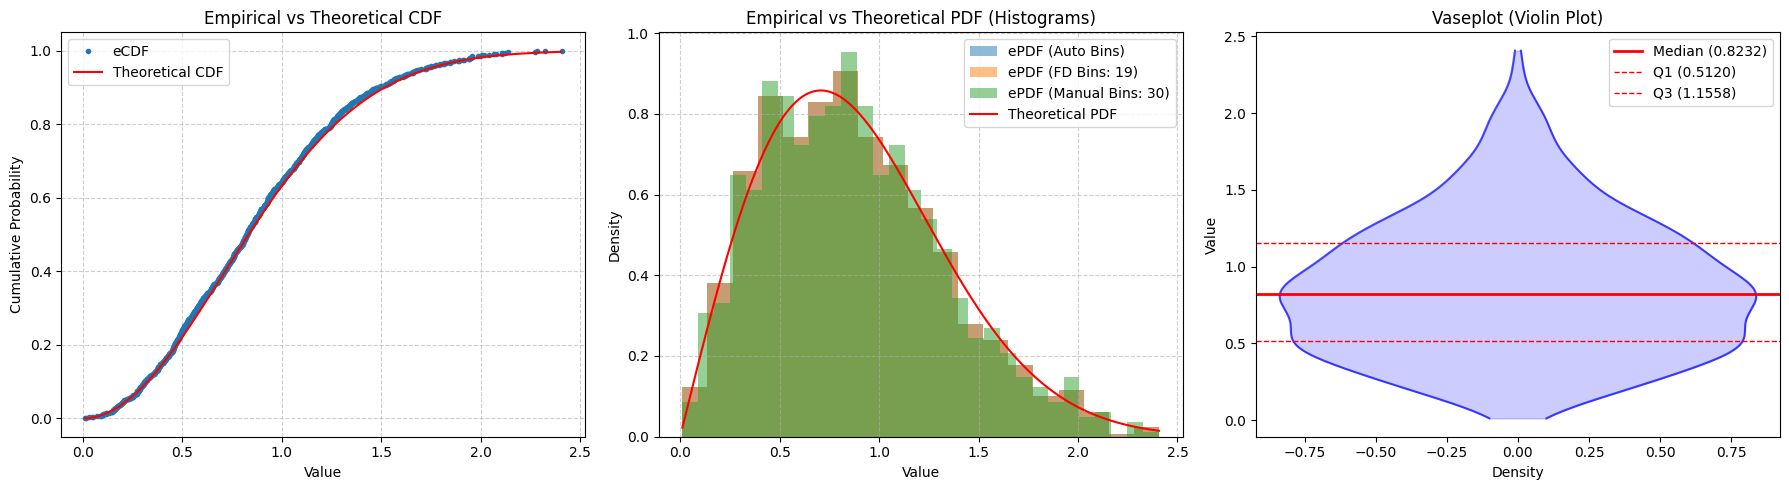

-----------------------------------------------


In [77]:
# --- Распределение Вейбулла ---

# Параметры распределения Вейбулла (shape k и scale lambda)
shape_weibull = 2.0
scale_weibull = 1.0

# 1. Генерация выборки
weibull_data = stats.weibull_min.rvs(c=shape_weibull, scale=scale_weibull, size=N)

# 2. Анализ и визуализация
weibull_analyzer = DistributionAnalyzer(weibull_data, dist_type='continuous', name='Weibull Distribution')

# a) основные статистики
weibull_analyzer.print_statistics()

# b) визуализация
# For continuous distribution, theoretical_dist should be from scipy.stats.weibull_min
weibull_analyzer.plot_distribution(theoretical_dist=stats.weibull_min(c=shape_weibull, scale=scale_weibull))



In [78]:
class StabilityAnalyzer:
    """
    Analyzes the stability of statistics under contamination.
    """
    def __init__(self, original_data: np.ndarray):
        self.original_data = original_data
        self.contamination_results = []

    def add_outliers_to_data(self, data: np.ndarray, contamination_level: float) -> np.ndarray:
        """Add outliers to a dataset based on IQR fence."""
        q1, q3 = np.percentile(data, [25, 75])
        iqr = q3 - q1
        lower_fence = q1 - 1.5 * iqr
        upper_fence = q3 + 1.5 * iqr

        n_outliers = int(len(data) * contamination_level)
        if n_outliers == 0:
            return data # No outliers to add

        # Generate outliers: random values beyond the fences
        # We can generate values far beyond the fence to ensure they are outliers
        outlier_values = np.random.uniform(low=upper_fence + iqr, high=upper_fence + 5*iqr, size=n_outliers // 2)
        outlier_values = np.concatenate((outlier_values, np.random.uniform(low=lower_fence - 5*iqr, high=lower_fence - iqr, size=n_outliers - (n_outliers // 2))))

        return np.concatenate([data, outlier_values])


    def evaluate_contamination_effect(self, contamination_levels: np.ndarray = np.linspace(0, 0.05, 11)):
        """Evaluate statistical measures under different contamination levels."""
        print("\n--- Evaluating Stability under Contamination ---")
        self.contamination_results = []
        for cl in contamination_levels:
            # Start with the original data for each contamination level
            contaminated_data = self.add_outliers_to_data(self.original_data, cl)
            analyzer = DistributionAnalyzer(contaminated_data)
            stats = analyzer.calculate_statistics()
            self.contamination_results.append({
                'level': cl,
                'mean': stats['mean'],
                'std': stats['std'],
                'iqr': stats['iqr'],
                'median': stats['median'], # Also track median for comparison
                'mad': stats['mad'] # Also track MAD for comparison
            })
            print(f"Processed contamination level: {cl:.2f}")

        print("--- Stability Evaluation Complete ---")
        return self.contamination_results

    def plot_stability(self):
        """Plot how statistics change with contamination levels."""
        if not self.contamination_results:
            print("Run evaluate_contamination_effect first.")
            return

        print("\n--- Plotting Stability ---")
        df_results = pd.DataFrame(self.contamination_results)

        fig, axes = plt.subplots(1, 3, figsize=(18, 5))

        # Plot Mean and Median
        axes[0].plot(df_results['level'], df_results['mean'], marker='o', label='Mean')
        axes[0].plot(df_results['level'], df_results['median'], marker='o', label='Median')
        axes[0].set_title('Mean and Median vs Contamination Level')
        axes[0].set_xlabel('Contamination Level')
        axes[0].set_ylabel('Value')
        axes[0].legend()
        axes[0].grid(True, linestyle='--', alpha=0.6)

        # Plot Standard Deviation and MAD
        axes[1].plot(df_results['level'], df_results['std'], marker='o', label='Standard Deviation')
        axes[1].plot(df_results['level'], df_results['mad'], marker='o', label='Mean Absolute Deviation')
        axes[1].set_title('Standard Deviation and MAD vs Contamination Level')
        axes[1].set_xlabel('Contamination Level')
        axes[1].set_ylabel('Value')
        axes[1].legend()
        axes[1].grid(True, linestyle='--', alpha=0.6)

        # Plot IQR
        axes[2].plot(df_results['level'], df_results['iqr'], marker='o', label='IQR')
        axes[2].set_title('IQR vs Contamination Level')
        axes[2].set_xlabel('Contamination Level')
        axes[2].set_ylabel('Value')
        axes[2].legend()
        axes[2].grid(True, linestyle='--', alpha=0.6)


        plt.tight_layout()
        plt.show()
        print("--- Stability Plotting Complete ---")

## Исследование устойчивости характеристик (для Распределения Вейбулла)



--- Evaluating Stability under Contamination ---
Processed contamination level: 0.00
Processed contamination level: 0.00
Processed contamination level: 0.01
Processed contamination level: 0.01
Processed contamination level: 0.02
Processed contamination level: 0.02
Processed contamination level: 0.03
Processed contamination level: 0.03
Processed contamination level: 0.04
Processed contamination level: 0.04
Processed contamination level: 0.05
Processed contamination level: 0.05
Processed contamination level: 0.06
Processed contamination level: 0.06
Processed contamination level: 0.07
Processed contamination level: 0.07
Processed contamination level: 0.08
Processed contamination level: 0.08
Processed contamination level: 0.09
Processed contamination level: 0.09
Processed contamination level: 0.10
Processed contamination level: 0.10
Processed contamination level: 0.11
Processed contamination level: 0.11
Processed contamination level: 0.12
Processed contamination level: 0.12
Processed cont

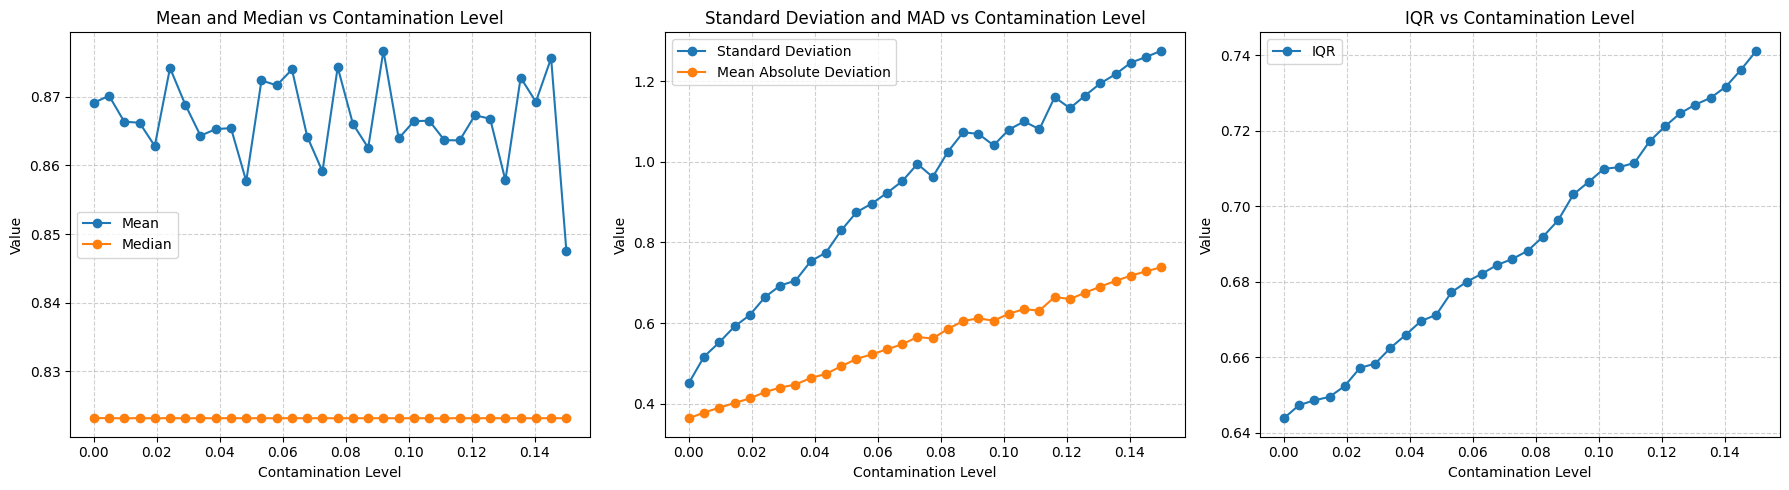

--- Stability Plotting Complete ---


In [79]:

# --- Исследование устойчивости для Распределения Вейбулла ---

# Создание анализатора устойчивости
stability_analyzer = StabilityAnalyzer(weibull_data)

# Оценка влияния выбросов на статистики
# Используем 11 процентных пунктов от 0% до 5%
contamination_levels = np.linspace(0, 0.15, 32)
stability_results = stability_analyzer.evaluate_contamination_effect(contamination_levels)

# Вывод результатов 
print("\nStability Analysis Results:")
for res in stability_results:
    print(f"Contamination Level: {res['level']:.2f}, Mean: {res['mean']:.4f}, Std: {res['std']:.4f}, IQR: {res['iqr']:.4f}")

# Построение графиков изменения мер вариабельности и центральной тенденции
stability_analyzer.plot_stability()